####  Import Libraries Section

In [46]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

import joblib

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv')

train.rename(columns={'KPIs_met >80%': 'kpis_met', 'awards_won?': 'awards_won' }, inplace=True)
test.rename(columns={'KPIs_met >80%': 'kpis_met', 'awards_won?': 'awards_won' }, inplace=True)
train.shape

(54808, 14)

#### Feature Engineering

In [3]:
# Categorical features preperation
categorical_transformer = Pipeline(
steps = [
    ('impute_cat', SimpleImputer(strategy='most_frequent')), # missing values
    ('ohe',OneHotEncoder(handle_unknown='ignore')) # categetoy encoding
])

In [4]:
# numerical features preperation

numerical_transformer = Pipeline(
steps = [
    ('impute_num', SimpleImputer(strategy='median')), # missing values
    ('scale',StandardScaler()) # standard scaler
])

In [5]:
# Step 1: Splitting Numerical and categorical columns
target_col  =['is_promoted']
ignore_col  =['employee_id', 'recruitment_channel'] 
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
numerical_columns  = numerical_columns.drop(['employee_id','is_promoted'])
categorical_columns = train.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop(['recruitment_channel'])

NameError: name 'no_of_trainings' is not defined

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ] 
)

In [7]:
#Create the pipeline with imputation and transformation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [8]:
X = train.drop(columns=ignore_col+target_col)
X.head(2)

,department,region,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met,awards_won,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,1,35,5.0,8,1,0,49
1,Operations,region_22,Bachelor's,m,1,30,5.0,4,0,0,60


In [9]:
y = train[target_col]
 

In [10]:
X.shape
 

(54808, 11)

#### Model Creation Section 
 - Train ad test Split
 - fit the model

In [11]:
# train test split
train_X, val_X, train_y, val_y = train_test_split(X,y, random_state=42, test_size=0.2)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((43846, 11), (10962, 11), (43846, 1), (10962, 1))

,department,region,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met,awards_won,avg_training_score
3872,Sales & Marketing,region_19,Bachelor's,m,1,31,5.0,5,1,0,48
11619,Technology,region_13,Master's & above,m,1,34,1.0,4,0,0,78
36178,Technology,region_22,Bachelor's,m,3,29,4.0,4,1,0,77
29884,Sales & Marketing,region_2,Master's & above,m,1,54,4.0,15,1,0,47
22968,R&D,region_7,Bachelor's,m,1,31,5.0,6,0,0,86
...,...,...,...,...,...,...,...,...,...,...,...
44732,Procurement,region_22,Master's & above,f,3,36,3.0,4,0,0,67
54343,Procurement,region_2,Bachelor's,f,1,27,NaN,1,0,0,68
38158,Operations,region_11,Bachelor's,f,1,34,5.0,7,1,0,65
860,Analytics,region_15,Master's & above,m,3,35,5.0,3,0,0,86


In [16]:
# fit the moel
pipeline.fit(train_X, train_y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'kpis_met', 'awards_won', 'avg_training_score'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['department', 'region', 'education', 'gender'], dtype='object'))])),
                ('model', LogisticRegression())])

In [17]:
# Make predictions
y_pred = pipeline.predict(val_X)


In [18]:
pipeline.predict_proba(val_X)


array([[0.99362555, 0.00637445],
       [0.98697886, 0.01302114],
       [0.96200478, 0.03799522],
       ...,
       [0.80910743, 0.19089257],
       [0.98695105, 0.01304895],
       [0.96726542, 0.03273458]])

In [19]:
# Evaluating model performance
print("Accuracy:", accuracy_score(val_y, y_pred))
print(classification_report(val_y, y_pred))

Accuracy: 0.9328589673417259
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10054
           1       0.80      0.25      0.38       908

    accuracy                           0.93     10962
   macro avg       0.87      0.62      0.67     10962
weighted avg       0.93      0.93      0.92     10962



In [20]:
# Increasing the score by oversampling
over_sampling = RandomOverSampler()
train_y.value_counts()

is_promoted
0              40086
1               3760
Name: count, dtype: int64

In [21]:
train_X_os, train_y_os = over_sampling.fit_resample(train_X,train_y)
# fit the moel
pipeline.fit(train_X_os, train_y_os)
y_pred_os = pipeline.predict(val_X)

In [22]:
# Evaluating model performance
print("Accuracy:", accuracy_score(val_y, y_pred_os))
print(classification_report(val_y,y_pred_os))

Accuracy: 0.771300857507754
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     10054
           1       0.24      0.84      0.38       908

    accuracy                           0.77     10962
   macro avg       0.61      0.80      0.62     10962
weighted avg       0.92      0.77      0.82     10962



In [23]:
train_y_os.value_counts()

is_promoted
0              40086
1              40086
Name: count, dtype: int64

#### HyperParameter Tuning Section

In [24]:
params_1 = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3]
    } 
]

In [25]:
params_1


[{'model': [LogisticRegression()],
  'model__penalty': ['l2', None],
  'model__C': [0.5, 3]}]

In [26]:
grid_LR = GridSearchCV(estimator=pipeline, param_grid=params_1, 
                    cv=2, scoring='roc_auc')

In [58]:
grid_LR.fit(train_X_os, train_y_os)
y_pred_os = pipeline.predict(val_X)

In [59]:
# Evaluating model performance
print("Accuracy:", accuracy_score(val_y, y_pred_os))
print(classification_report(val_y,y_pred_os))

Accuracy: 0.771300857507754
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     10054
           1       0.24      0.84      0.38       908

    accuracy                           0.77     10962
   macro avg       0.61      0.80      0.62     10962
weighted avg       0.92      0.77      0.82     10962



----------------------------------------------------------------

Train Accuracy
0.7865084748641484
Valid Accuracy
0.8031894290654256
----------------------------------------------------------------

Train confusion matrix
[[30646  9440]
 [  720  3040]]
Valid  confusion matrix
[[7691 2363]
 [ 144  764]]
----------------------------------------------------------------

Train classification report
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     40086
           1       0.24      0.81      0.37      3760

    accuracy                           0.77     43846
   macro avg       0.61      0.79      0.62     43846
weighted avg       0.91      0.77      0.82     43846

Valid classification report
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     10054
           1       0.24      0.84      0.38       908

    accuracy                           0.77     10962
   macro avg       0.61     

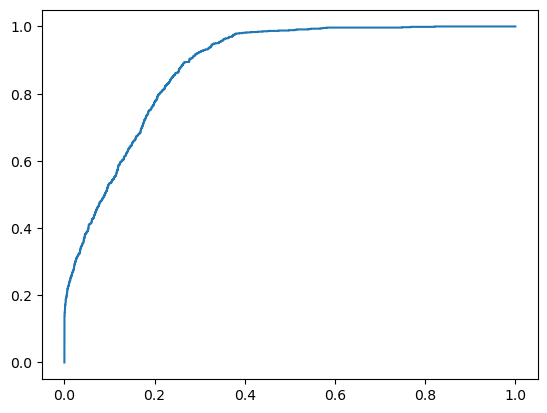

In [60]:
pred_train_tgt = pipeline.predict(train_X)
pred_val_tgt   = pipeline.predict(val_X)
print('----------------------------------------------------------------\n')
print('Train Accuracy', roc_auc_score(train_y,pred_train_tgt),sep='\n')
print('Valid Accuracy', roc_auc_score(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
print('Train confusion matrix', confusion_matrix(train_y,pred_train_tgt),sep='\n')
print('Valid  confusion matrix', confusion_matrix(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
print('Train classification report', classification_report(train_y,pred_train_tgt),sep='\n')
print('Valid classification report', classification_report(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
# plot roc Curve
y_pred_proba = pipeline.predict_proba(val_X)[:,1]
plt.figure()
fpr, tpr, thrsh = roc_curve(val_y,y_pred_proba)
 

plt.plot(fpr, tpr)
plt.show()

In [62]:
joblib.dump(pipeline,'promotion_pipeline_model.pkl')

['promotion_pipeline_model.pkl']

In [61]:
train_X

,department,region,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met,awards_won,avg_training_score
3872,Sales & Marketing,region_19,Bachelor's,m,1,31,5.0,5,1,0,48
11619,Technology,region_13,Master's & above,m,1,34,1.0,4,0,0,78
36178,Technology,region_22,Bachelor's,m,3,29,4.0,4,1,0,77
29884,Sales & Marketing,region_2,Master's & above,m,1,54,4.0,15,1,0,47
22968,R&D,region_7,Bachelor's,m,1,31,5.0,6,0,0,86
...,...,...,...,...,...,...,...,...,...,...,...
44732,Procurement,region_22,Master's & above,f,3,36,3.0,4,0,0,67
54343,Procurement,region_2,Bachelor's,f,1,27,NaN,1,0,0,68
38158,Operations,region_11,Bachelor's,f,1,34,5.0,7,1,0,65
860,Analytics,region_15,Master's & above,m,3,35,5.0,3,0,0,86


In [32]:
#Checking the Sample in the hackathon website
train.columns.difference(test.columns)


Index(['is_promoted'], dtype='object')

In [33]:
submit_LR  = sample
submit_LR['is_promoted'] = pipeline.predict(test)

In [34]:
submit_LR.to_csv('sub_1.csv',index=False)

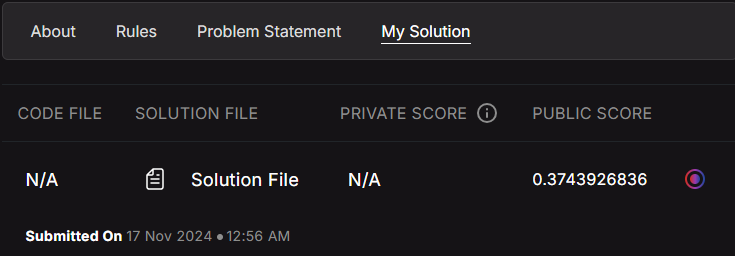

In [48]:
#Create the pipeline with imputation and transformation
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state =22 ,n_estimators=100))
])

In [ ]:
rf_pipeline.fit(train_X_os, train_y_os)
#y_pred_rf_os = rf_pipeline.predict(val_X)

In [38]:
y_pred_rf_os = rf_pipeline.predict(val_X)

In [39]:
# Evaluating model performance
print("Accuracy:", accuracy_score(val_y, y_pred_rf_os))
print(classification_report(val_y,y_pred_rf_os))

Accuracy: 0.9262908228425469
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10054
           1       0.58      0.38      0.46       908

    accuracy                           0.93     10962
   macro avg       0.77      0.68      0.71     10962
weighted avg       0.92      0.93      0.92     10962



----------------------------------------------------------------

Train Accuracy
0.9996632240682533
Valid Accuracy
0.6787956269624206
----------------------------------------------------------------

Train confusion matrix
[[40059    27]
 [    0  3760]]
Valid  confusion matrix
[[9807  247]
 [ 561  347]]
----------------------------------------------------------------

Train classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       0.99      1.00      1.00      3760

    accuracy                           1.00     43846
   macro avg       1.00      1.00      1.00     43846
weighted avg       1.00      1.00      1.00     43846

Valid classification report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10054
           1       0.58      0.38      0.46       908

    accuracy                           0.93     10962
   macro avg       0.77     

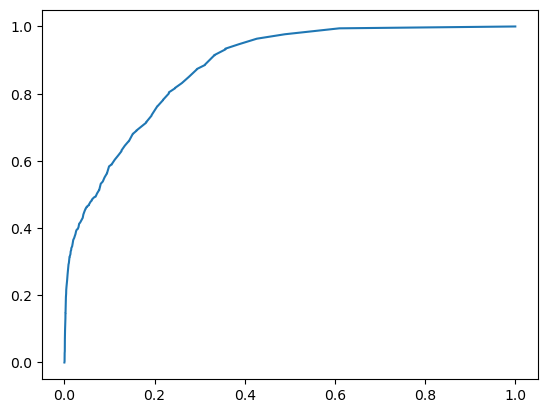

In [43]:
pred_train_tgt = rf_pipeline.predict(train_X)
pred_val_tgt   = rf_pipeline.predict(val_X)
print('----------------------------------------------------------------\n')
print('Train Accuracy', roc_auc_score(train_y,pred_train_tgt),sep='\n')
print('Valid Accuracy', roc_auc_score(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
print('Train confusion matrix', confusion_matrix(train_y,pred_train_tgt),sep='\n')
print('Valid  confusion matrix', confusion_matrix(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
print('Train classification report', classification_report(train_y,pred_train_tgt),sep='\n')
print('Valid classification report', classification_report(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
# plot roc Curve
y_pred_proba = rf_pipeline.predict_proba(val_X)[:,1]
plt.figure()
fpr, tpr, thrsh = roc_curve(val_y,y_pred_proba)
 

plt.plot(fpr, tpr)
plt.show()

['promotion_pipeline_model.pkl']

#### HyperParameter Tunning

In [51]:
params_2 = [
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',RandomForestClassifier(random_state =22 ,n_estimators=100)], ] 

    )],
    'model__sclf1__max_depth':[4,8,12],
   # 'model__sclf1__n_estimators':[15,25],    
  #  'model__sclf3__n_estimators':[5,35],
    } 
]

In [52]:
grid_RF = GridSearchCV(estimator=rf_pipeline, param_grid=params_2, 
                    cv=2, scoring='roc_auc')
grid_RF.fit(train_X_os, train_y_os)


KeyboardInterrupt: 

In [ ]:
grid_RF.best_estimator_

In [ ]:
grid_RF.get_params

In [ ]:
grid_RF.best_params_


In [ ]:
y_pred_rf_os = rf_pipeline.predict(val_X)
# Evaluating model performance
print("Accuracy:", accuracy_score(val_y, y_pred_rf_os))
print(classification_report(val_y,y_pred_rf_os))

In [ ]:
# updating the existing target values with predicted values
submit_RF  = sample
submit_RF['is_promoted'] = rf_pipeline.predict(test)

In [ ]:
submit_RF.to_csv('sub_rf_01.csv',index=False)

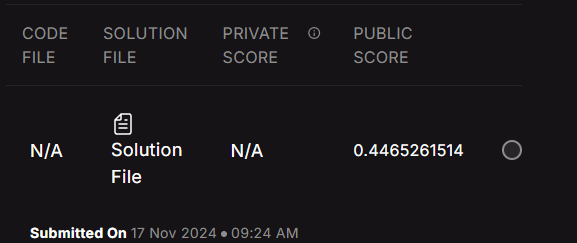

In [ ]:
grid_RF

In [ ]:
submit_RF  = sample
submit_RF['is_promoted'] = rf_pipeline.predict(test)

In [ ]:
submit_RF.to_csv('sub_rf.csv',index=False)

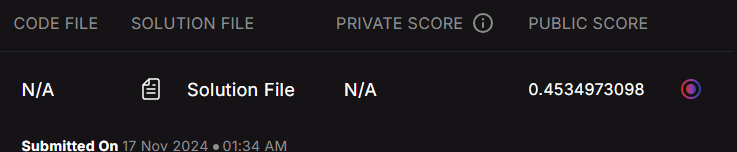

In [ ]:
params_3 = [
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',RandomForestClassifier(random_state=22)], 
       ['sclf2',GradientBoostingClassifier()],
         ['sclf3',AdaBoostClassifier()],
    ] )],
    'model__sclf1__max_depth':[4,8,12],
    'model__sclf2__n_estimators':[15,25, 35],    
    'model__sclf3__n_estimators':[5,35],
    } 
]

In [ ]:
grid_RF = GridSearchCV(estimator=rf_pipeline, param_grid=params_3, 
                    cv=2, scoring='roc_auc')
grid_RF.fit(train_X_os, train_y_os)

In [ ]:
grid_RF.best_params_


In [ ]:

res_df = pd.DataFrame(grid_RF.cv_results_,)
pd.set_option('display.max_colwidth',100)
res_df[['params','mean_test_score','rank_test_score']]

In [ ]:
grid_RF.cv_results_

In [ ]:
submit_RF_01  = sample
submit_RF_01['is_promoted'] = rf_pipeline.predict(test)

In [ ]:
submit_RF_01.to_csv('sub_rf_02.csv',index=False)

In [ ]:
pred_train_tgt = rf_pipeline.predict(train_X)
pred_val_tgt   = rf_pipeline.predict(val_X)
print('----------------------------------------------------------------\n')
print('Train Accuracy', roc_auc_score(train_y,pred_train_tgt),sep='\n')
print('Valid Accuracy', roc_auc_score(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
print('Train confusion matrix', confusion_matrix(train_y,pred_train_tgt),sep='\n')
print('Valid  confusion matrix', confusion_matrix(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
print('Train classification report', classification_report(train_y,pred_train_tgt),sep='\n')
print('Valid classification report', classification_report(val_y,pred_val_tgt),sep='\n')
print('----------------------------------------------------------------\n')
# plot roc Curve
y_pred_proba = rf_pipeline.predict_proba(val_X)[:,1]
plt.figure()
fpr, tpr, thrsh = roc_curve(val_y,y_pred_proba)
 

plt.plot(fpr, tpr)
plt.show()